# Comparing performance
The two methods are compared in this `.ipynb`. 


The MCMC Metropolis-Hastings algorithm MCPass is defined as a trial spin rotation of each spin in the lattice.

The Wolff algorithm MCPass is defined as a single cluster spin rotation.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from itertools import product
from copy import deepcopy
import os
import re
from glob import glob
from tqdm.auto import tqdm

%cd /content/drive/My\ Drive/Thesis/thesis/data
%ls

# data location
root_mc = "./MCMC-performance"
root_wo = "./Wolff-performance"

# constants
observables = ["E", "M"]
soorten = ["mc", "wo"]
L_range = [8,16,32,48,64]
T_range = np.linspace(0.1, 3.0, 64)
T_range = np.concatenate((T_range[0:13:4],T_range[12:24:1],T_range[23:64:4]))

/content/drive/My Drive/Thesis/thesis/data
configstemp/  configsTrain/   MCMC-performance/  Wolff-performance/
configsTest/  corrs_data.npy  obsData.npy



## Timing
Comparison of how long 1 MCPass takes.

In [2]:
# Getting the data
def get_timing_data(root, L):
  filename = f"times-L={L} (1).npy" # is newer, all L done w same cpu load etc
  if not os.path.isfile(filename):
    filename = f"times-L={L}.npy"
  
  data = np.load(os.path.join(root, filename))
  return data

data_time_wo = np.zeros((len(T_range), len(L_range), 2))
data_time_mc = np.zeros((len(T_range), len(L_range), 2))
for i,L in enumerate(L_range):  
  data_time_wo[:,i,:] = get_timing_data(root_wo,L) 
  data_time_mc[:,i,:] = get_timing_data(root_mc,L) 


Text(0.5, 0, 'Size $L$ $[1]$')

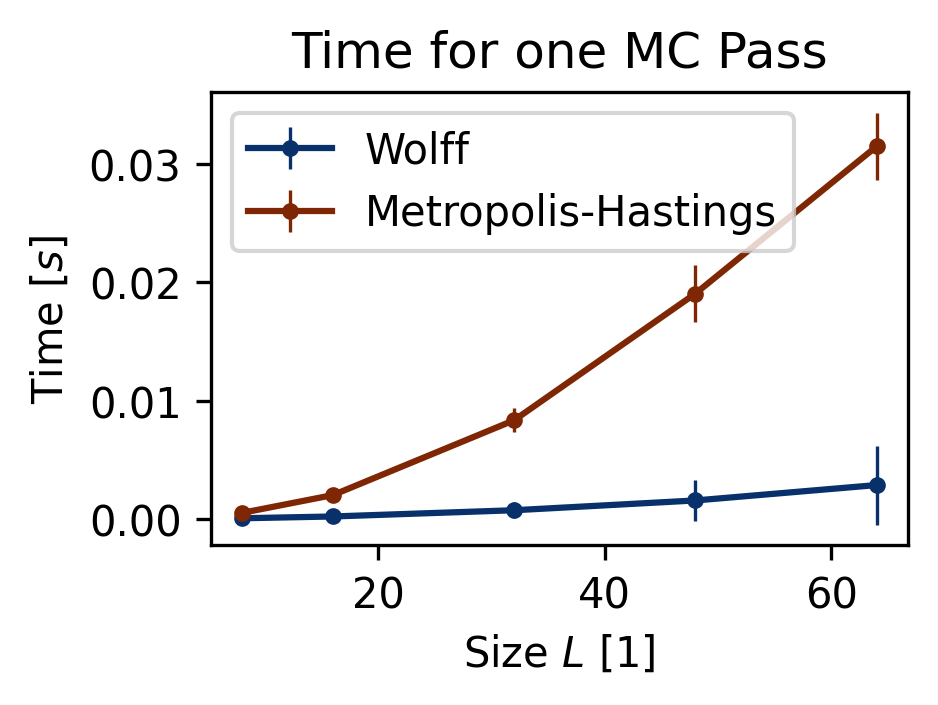

In [3]:
# Plotting
T_indices = [0,13,14,26]

blues = cm.get_cmap("Blues", len(T_indices))
oranges = cm.get_cmap("Oranges", len(T_indices))
markers = ["o", "v", "d", "s", "^", "*", "<", ">"]

fig, ax = plt.subplots(figsize=(3,2),dpi=300)

def calcMeans(data):
  a = np.zeros((len(L_range), 2))
  for i in range(len(L_range)):
    d = data[:,i,0]
    a[i,:] = d.mean(), d.std()
  return a

def plot_avg(ax, *args):
  """Plots average time and std for mcPass in function of system size.
  Averages etc calculated across all temperatures."""
  ax.errorbar(L_range, calcMeans(data_time_wo)[:,0], yerr=calcMeans(data_time_wo)[:,1], marker=markers[0], c=blues(len(T_indices)), label="Wolff", lw=1.5, ms=3, elinewidth=0.8)
  ax.errorbar(L_range, calcMeans(data_time_mc)[:,0], yerr=calcMeans(data_time_mc)[:,1], marker=markers[0], c=oranges(len(T_indices)), label="Metropolis-Hastings", lw=1.5, ms=3, elinewidth=0.8)
  ax.legend()

def plot_times(ax, T_idx, iidx):
  """For certain temperature, plots average time in function of system size
  on the ax object. T_idx is index of which temperature.
  iidx is needed to change color every time this fion is called."""
  ax.plot(L_range[:5], data_time_wo[T_idx,:5,0], marker=markers[0], c=blues(iidx), lw=1.5, ms=3)
  ax.plot(L_range[:5], data_time_mc[T_idx,:5,0], marker=markers[0], c=oranges(iidx), lw=1.5, ms=3)

for iidx, T_idx in enumerate(T_indices):
  break
  plot_times(ax, T_idx, iidx)
plot_avg(ax, T_idx, iidx)


plt.title("Time for one MC Pass")
plt.ylabel(r"Time $[s]$")
plt.xlabel(r"Size $L$ $[1]$")


## Correlation

Comparison of how fast the correlation drops in function of the amount of MCpasses that have passed. Also a measure for the efficiency of the algorithm, taken into account the average time of a single MCPass.

Important note: For honest comparison, the size of the flipped cluster in the Wolff MCPass is important. See `Walter and Barkema - 2015 - An introduction to Monte Carlo methods`


In [10]:
# init
N_chain = 2000

%cd /content/drive/My\ Drive/Thesis
from util import * 
%cd /content/drive/My\ Drive/Thesis/thesis/data

def create_empty_dict(N):
  return {soort: {L: {obs: np.zeros(N) for obs in observables} for L in L_range} for soort in soorten}

def genRandData():
  sd = {obs: np.random.rand(N_chain) for obs in observables}
  return sd # dict w 'shape' 4,27

def calcObs(configs, obs):
  #configs.shape = 2000,L,L
  # obs from ["E", "M", "Cv", "X"]
  if obs == "E":
    return np.array(list(map(calcAvgEnergy,configs)))
  elif obs == "M":
    return np.array(list(map(calcSquaredMeanMag, configs)))

def calcObsFromConfigs(configs):
  # configs.shape = 2000, L, L
  return {obs: calcObs(configs, obs) for obs in observables}

def obsDataWO_load(L):
  filename = os.path.join(root_wo, f"obs-L={L}.npy")
  obsData = np.load(filename)
  # obsData.shape = 27,2,2000
  return {T: {obs: obsData[i,j,:] for j, obs in enumerate(observables)} for i,T in enumerate(T_range)}

def obsDataMC_TL_load(L, T):
  filename = os.path.join(root_mc, f"extra_configs_newobs__T={T}_L={L}.npy")
  obsData_T_L = np.load(filename) 
  # obsData_T_L.shape = 2, 2000 
  return {obs: obsData_T_L[i] for i, obs in enumerate(observables)}

/content/drive/My Drive/Thesis
/content/drive/My Drive/Thesis/thesis/data


In [16]:
# calculating correlations is quite expensive
corr_T_range = T_range[:-2]

# custom
corr_T_range = np.linspace(0.1, 3.0, 64)
corr_T_range = np.concatenate((corr_T_range[0:13:4],corr_T_range[12:24:1],corr_T_range[23:64:4]))
corr_T_range = T_range[::3]

print(corr_T_range)

corr_L_range = [8,32]
corr_observables = ["M"]
corr_soorten = soorten
corr_combos = list(product(corr_soorten, corr_L_range, corr_T_range, corr_observables))

# load obs data
obs_filename = "obsData_calcSquaredMeanMag.npy" # obsdata 2 uses just "calcSquaredMeanMag"
refreshObs = True

if os.path.isfile(obs_filename) and not refreshObs:
  REAL_obsData = np.load(obs_filename, allow_pickle=True).item()
else:
  try:
    REAL_obsData
    print("Observables data already loaded in.")
  except NameError: # REAL_obsData does not yet exist
    REAL_obsData = {soort:dict() for soort in corr_soorten}
    for soort in corr_soorten:
      if soort == "mc":
        REAL_obsData[soort] = {L: {T: obsDataMC_TL_load(L, T) for T in corr_T_range} for L in corr_L_range}
      elif soort == "wo":
        REAL_obsData[soort] = {L: obsDataWO_load(L) for L in corr_L_range}
    print("Observables data loaded in.")
    np.save(obs_filename, REAL_obsData)

[0.1        0.65238095 0.74444444 0.88253968 1.02063492 1.15873016
 1.52698413 2.07936508 2.63174603]
Observables data loaded in.


### Calculations

With data for each observable consisting of ~2000 values, the correlation can be calculated for certain `k` values.

In [17]:
# loads file if exists
# calculates corrs if not present in data from file
corr_filename = "corrs_data.npy"



num_k_points = 500 #  1 < num_k_points <= max_k: amount of points where corr is calculated
max_k = 500
k_range = np.unique(np.linspace(1, max_k, num=num_k_points, dtype=int))
if not os.path.isfile(corr_filename):
  print("File with correlation data not found. Generating correlation data.")
  # data shape must be 2, 5, 27, 4, 2000 
  # soorten, L, T, obs, N_chain

  # calculate correlations
  corrs = {soort: {L: {T: {obs: np.zeros(num_k_points) for obs in observables} for T in T_range} for L in L_range} for soort in soorten}

  # ! limit to L = [8,32] and T = [0.35,0.95,1.90] to begin with

  for i, (soort, L, T, obs) in tqdm(enumerate(corr_combos), f"correlation: ", total=len(corr_observables)*len(corr_T_range)*len(corr_L_range)*len(corr_soorten)):
    corrs[soort][L][T][obs] = np.array([calcAutoCorr_for_k(REAL_obsData[soort][L][T][obs], k) for k in k_range])

  # saving this data 
  np.save(corr_filename, corrs)
else:
  print(f"Using correlation data from existing file @ {corr_filename}")
  corrs = np.load(corr_filename, allow_pickle=True).item()

  calcCnt = 0
  for i, (soort, L, T, obs) in tqdm(enumerate(corr_combos), f"checking: ", total=len(corr_observables)*len(corr_T_range)*len(corr_L_range)*len(corr_soorten)):
    if np.any(corrs[soort][L][T][obs]):
      continue
    else:
      calcCnt += 1
      corrs[soort][L][T][obs] = np.array([calcAutoCorr_for_k(REAL_obsData[soort][L][T][obs], k) for k in k_range])
  if calcCnt > 0:
    print(f"\nSaving updated correlation data file @ {corr_filename}")
    np.save(corr_filename, corrs)

File with correlation data not found. Generating correlation data.


correlation: 100%|██████████| 36/36 [00:28<00:00,  1.25it/s]


In [ ]:
print(corr_T_range)
soort, L, T, obs = "mc", 32, corr_T_range[1], "M"
vb = corrs[soort][L][T][obs]

for e in vb:
  print(e)
print("REAL DATA")
for e in REAL_obsData[soort][L][T][obs]:
  print(e)


### Plotting
We make use of the `corr_X` variables instead of `X` because calculating correlations for all data is expensive. 

That would be `2.5.27.2 = 540` sets of `2000` correlation points.


#### Simple plot of Autocorrelation data

The autocorrelation shows how one thing is related to the other. We will compare the initial configuration with configs `k` mcPasses later. 

This value should be between `-1` and `1`.

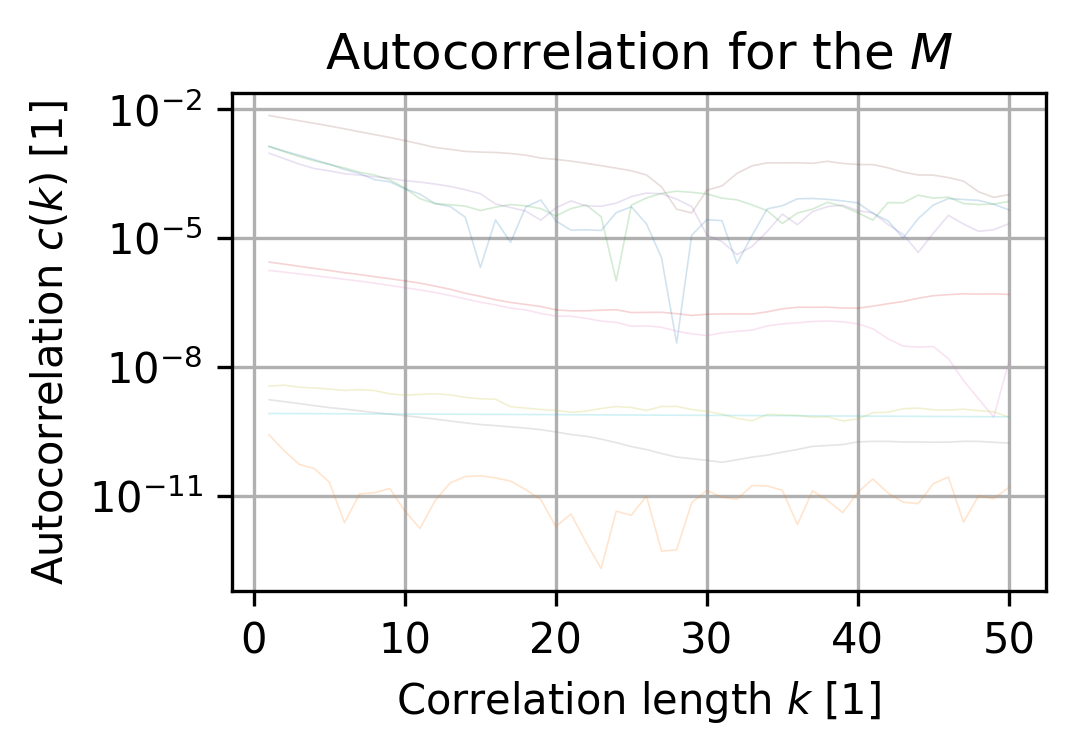

In [39]:
# simple plot showing autocorrelation c(k)
begin_idx, end_idx = 0,50

plt_k = k_range[begin_idx:end_idx]

fig, ax = plt.subplots(figsize=(3.5,2.2),dpi=300)
ax.set_ylabel(r"Autocorrelation $c(k)$ $[1]$")
ax.set_xlabel(r"Correlation length $k$ $[1]$")

num_random_plots = 10
ax.set_title(fr"Autocorrelation for the ${corr_combos[0][3]}$")
for i in np.random.choice(list(range(len(corr_combos))), num_random_plots, replace=False):
  soort, L, T, obs = corr_combos[i]
  plt_corr = corrs[soort][L][T][obs][begin_idx:end_idx]
  ax.semilogy(plt_k, np.abs(plt_corr), label=fr"{soort}: $L={L}$,$T={T:.2f}$", lw=.4, alpha=min(1,2/num_random_plots))
if num_random_plots <= 4:
  ax.legend()
ax.grid(True, which="both", ls='-')

#### Fitted plot of Autocorrelation data
Only use a certain amount of data for each fit. Untill correlation dropped below 5% of original correlation.

In [ ]:
# from matplotlib.ticker import MaxNLocator
# # new plots
# figlow, axlow = plt.subplots(dpi=500, figsize=(3,3.75))
# figcrit, axcrit = plt.subplots(dpi=500, figsize=(3,3.75))
# fighigh, axhigh = plt.subplots(dpi=500, figsize=(3,3.75))

# for TL in TL_str:
#     # only use fit when correlation is more than 5% its initial value
#     x, corr = k_range[begin_idx:], corrs[TL][begin_idx:]
#     end_idx = min([i for i, co in enumerate(corr) if co < .05*corr[0]] + [len(corr)])
#     x, corr = k_range[begin_idx:end_idx], corrs[TL][begin_idx:end_idx]

#     # plot data & fit
#     if TL[0][1] == "low":
#         axlow.semilogy(x, corr, lw=1.012, label=f"L={TL[1]}, {TL[0][1]} T", 
#         c = "tab:blue" if TL[1]==8 else "tab:orange", alpha=.75)
#         axlow.semilogy(x, [corr_fit_function(x_, *fit_pms[TL]) for x_ in x], 
#         "--", c = "tab:blue" if TL[1]==8 else "tab:orange",  
#         label=f"fit ~ exp ( - x / {fit_pms[TL][1]:.2f} )")

#     elif TL[0][1] == "crit":
#         print(x, corr)
#         axcrit.semilogy(x, corr, lw=1.012, label=f"L={TL[1]}, {TL[0][1]} T", 
#         c = "tab:blue" if TL[1]==8 else "tab:orange", alpha=.75)
#         axcrit.semilogy(x, [corr_fit_function(x_, *fit_pms[TL]) for x_ in x],
#         "--", c = "tab:blue" if TL[1]==8 else "tab:orange", 
#         label=f"fit ~ exp ( - x / {fit_pms[TL][1]:.2f} )")

#     elif TL[0][1] == "high":
#         axhigh.semilogy(x, corr, lw=1.012, label=f"L={TL[1]}, {TL[0][1]} T", 
#         c = "tab:blue" if TL[1]==8 else "tab:orange", alpha=.75)
#         axhigh.semilogy(x, [corr_fit_function(x_, *fit_pms[TL]) for x_ in x],
#         "--", c = "tab:blue" if TL[1]==8 else "tab:orange", 
#         label=f"fit ~ exp ( - x / {fit_pms[TL][1]:.2f} )")

# print("fit parameters")
# print(fit_pms)
# print("fit variances")
# print(fit_vars)

# for ax in [axlow, axcrit, axhigh]:
#     ax.legend()
#     ax.set_xlabel(r"Correlation length $k$", fontsize=14)
#     ax.set_ylabel(r"Autocorrelation $c(k)$", fontsize=14)
#     ax.set_yticklabels([])
    
#     #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# #ax.locator_params(nbins=4)

# for TL in TL_str:
#     # only use fit when correlation is more than 5% its initial value
#     x, corr = k_range[begin_idx:], corrs[TL][begin_idx:]
#     begin_idx_ = min([i for i, co in enumerate(corr) if co < .05*corr[0]] + [len(corr)])

#     if TL[1] == 8:
#         if TL[0][1] == "low":
#             end_idx = 730
#         elif TL[0][1] == "crit":
#             end_idx = 121
#         elif TL[0][1] == "high":
#             end_idx = 22
#         x, corr = k_range[begin_idx_-1:end_idx], corrs[TL][begin_idx_-1:end_idx]
#         if TL[0][1] == "low":
#             axlow.semilogy(x, corr, lw=1.012, 
#             c = "tab:blue" if TL[1]==8 else "tab:orange", alpha=.45)
#         elif TL[0][1] == "crit":
#             axcrit.semilogy(x, corr, lw=1.012, 
#             c = "tab:blue" if TL[1]==8 else "tab:orange", alpha=.45)
#         elif TL[0][1] == "high":
#             axhigh.semilogy(x, corr, lw=1.012, 
#             c = "tab:blue" if TL[1]==8 else "tab:orange", alpha=.45)

#### Plot of Autocorrelation Time
Get autocorrelation time from fitted plot earlier. Plot in function of T and L.

In [ ]:
# print("fit parameters")
# print(fit_pms)
# print()
# print("fit variances")
# print(fit_vars)

# fig,ax = plt.subplots(dpi=500, figsize=(6,4))

# Ts = [0.35,0.95,1.9]
# small = [0,0,0]
# big = [0,0,0]
# varsSmall = [0,0,0]
# varsBig = [0,0,0]
# for TL in TL_str:
#     if TL[1]==8:
#         i = 0 if TL[0][0]==0.35 else (1 if TL[0][0]==0.95 else 2)
#         small[i] = fit_pms[TL][1]
#         varsSmall[i] = np.sqrt(fit_vars[TL][1][1]) 
#     else:
#         i = 0 if TL[0][0]==0.35 else (1 if TL[0][0]==0.95 else 2)
#         big[i] = fit_pms[TL][1]
#         varsBig[i] = np.sqrt(fit_vars[TL][1][1]) 
# print(varsSmall, small)


# ax.semilogy(Ts, small, marker="v", label="L=8")
# ax.semilogy(Ts, big, marker="^", label="L=32")

# ax.set_xticks([0.35,0.95,1.90])
# ax.set_xticklabels([r"$T_{low} \approx 0.35$", r"$T_{crit} \approx 0.95$", r"$T_{high} \approx 1.90$"])
# ax.set_xlabel("Temperature", fontsize=14)
# ax.set_ylabel("Autocorrelation time", fontsize=14)
# ax.legend()